In [2]:
import os 
import sys
import argparse
import evolocity as evo
import anndata
import pandas as pd
import numpy as np
import torch
import scanpy as sc


### HYPERPARAMETERS TO CHANGE

In [69]:
dataset = "OVA_mouse"
mode = "full_VDJ"
group = "v_gene"
include_germline = False
no_IGM = False
no_IGD = False
only_IGM = False


### EVO_VELOCITY W/O GROUPING

In [ ]:

if __name__ == "__main__":

    model_names = ["ablang","sapiens","protbert","ESM"]
    data = pd.read_csv(os.path.join("..","..","..","data",dataset,"vdj_evolike_combine.csv"))

    data_folder_path = os.path.join("..","..","..","data",dataset,"VDJ")
    germlines_path = os.path.join("..","..","..","data",dataset,"all_germline_embeddings")

    IgG_subtypes = ["IGHG1","IGHG2B","IGHG2C","IGHG3"]

    model_dict = {}

    for i, model in enumerate(model_names):

        pooled_embeds = []
        
        for _,sample in (data[["original_sample_id","sample_id"]].drop_duplicates().iterrows()):
            
            cellranger_path = os.path.join(data_folder_path, sample["original_sample_id"])   
            embeddings_path = os.path.join(cellranger_path,"embeddings",mode,f"embeddings_{model}.csv.gzip")

            embeddings_file = pd.read_csv(embeddings_path, compression="gzip")
            embeddings_file = embeddings_file.loc[embeddings_file["chain"] == "IGH",:].reset_index(drop=True)
            embeddings_file["c_gene"] = embeddings_file["c_gene"].replace(IgG_subtypes,"IGHG")
            embeddings_file["v_gene_family"] = embeddings_file["v_gene"].apply(lambda x: x.split('-')[0])
            embeddings_file["sample_id"] = sample["sample_id"]

            embedding_cols = [col for col in list(embeddings_file.columns) if col.startswith("dim")]
            metadata_cols = list(set(embeddings_file.columns) - set(embedding_cols))

            embeddings_file = embeddings_file.drop_duplicates(embedding_cols).reset_index(drop=True)
            embeddings_file = embeddings_file.dropna(subset=embedding_cols)

            pooled_embeds += embeddings_file.to_dict(orient="records")

        pooled_embeds = pd.DataFrame(pooled_embeds)
        
        pooled_embeds["barcode"] = pooled_embeds["barcode"].apply(lambda x: x.split("-")[0])
        pooled_embeds = pooled_embeds.merge(data, on="barcode",suffixes=('', '_y'))

        embedding_cols = [col for col in list(pooled_embeds.columns) if col.startswith("dim")]
        metadata_cols = list(set(pooled_embeds.columns) - set(embedding_cols))

        if include_germline:
            germline_embeddings = pd.read_csv(os.path.join(germlines_path,f"all_germline_embeddings_{model}.csv.gzip"), compression="gzip")
            germline_embeddings["full_VDJ_aa"] = germline_embeddings["VDJ_ref.aa"].apply(lambda x: x.replace("-","").replace("*",""))
            # germline_embeddings["barcode"] = germline_embeddings["barcode"].apply(lambda x: x.split("_")[1])
            germline_embeddings = germline_embeddings.merge(data, on="barcode",suffixes=('', '_y'))
            germline_embeddings["barcode"] = "germline"
            germline_embeddings["c_gene"] = germline_embeddings["c_gene"].replace(IgG_subtypes,"IGHG")
            germline_embeddings["v_gene_family"] = germline_embeddings["v_gene"].apply(lambda x: x.split('-')[0])
            germline_embeddings = germline_embeddings.to_dict(orient="records")
         
            pooled_embeds = pooled_embeds.to_dict(orient="records")
            pooled_embeds += germline_embeddings
            pooled_embeds = pd.DataFrame(pooled_embeds)

        only_embeddings = pooled_embeds[embedding_cols].copy()
        metadata = pooled_embeds[metadata_cols].copy()
        
        try:
            torch.cuda.empty_cache()
                    
            adata = anndata.AnnData(only_embeddings)
            adata.obs["seq"] = list(metadata["full_VDJ_aa"])
            adata.obs["barcode"] = list(metadata["barcode"])
            
            adata.obs["v_gene_family"] = list(metadata["v_gene_family"])
            adata.obs["v_gene_family"] = adata.obs["v_gene_family"].astype("category")
               
            adata.obs["sample_id"] = list(metadata["sample_id"]) 
            
            adata.obs["sample_clonotype"] = list(metadata.apply(lambda x: x["sample_id"] + "_" + x["raw_clonotype_id"], axis = 1))
            adata.obs["sample_clonotype_encoded"] = pd.factorize(adata.obs["sample_clonotype"])[0]

            if include_germline:
                germline_indicator = list(metadata["barcode"] == "germline")
                adata.obs.loc[germline_indicator,"v_gene_family"] = "germline"
                adata.obs.loc[germline_indicator,"sample_id"] = "germline"
        
            evo.pp.neighbors(adata)

            if model == "ESM":
                evo.tl.velocity_graph(adata)
            else:
                evo.tl.velocity_graph(adata, model_name=model)

            del adata.uns['model']
            
            model_dict[model] = adata
            
            del(adata)
            
            
        except:
            continue


### EVO-VELOCITY WITH GROUPING

In [34]:
#### ALL SAMPLES PER V GENE FAMILY WITH GERMLINE ######
model_names = ["ablang","sapiens","ESM","protbert"]
data = pd.read_csv(os.path.join("..","..","..","data",dataset,"vdj_evolike_combine.csv"))

data_folder_path = os.path.join("..","..","..","data",dataset,"VDJ")
germlines_path = os.path.join("..","..","..","data",dataset,"all_germline_embeddings")

IgG_subtypes = ["IGHG1","IGHG2B","IGHG2C","IGHG3"]

model_dict = {}

for i, model in enumerate(model_names):

    pooled_embeds = []
    group_dict = {}
    
    for _,sample in (data[["original_sample_id","sample_id"]].drop_duplicates().iterrows()):
        
        cellranger_path = os.path.join(data_folder_path, sample["original_sample_id"])   
        embeddings_path = os.path.join(cellranger_path,"embeddings",mode,f"embeddings_{model}.csv.gzip")

        embeddings_file = pd.read_csv(embeddings_path, compression="gzip")
        embeddings_file = embeddings_file.loc[embeddings_file["chain"] == "IGH",:].reset_index(drop=True)
        embeddings_file["c_gene"] = embeddings_file["c_gene"].replace(IgG_subtypes,"IGHG")

        ### no IGHM
        if no_IGM:
            embeddings_file = embeddings_file.loc[embeddings_file["c_gene"] != "IGHM",:]

        ###
        
        embeddings_file["v_gene_family"] = embeddings_file["v_gene"].apply(lambda x: x.split('-')[0])
        embeddings_file["sample_id"] = sample["sample_id"]

        embedding_cols = [col for col in list(embeddings_file.columns) if col.startswith("dim")]
        metadata_cols = list(set(embeddings_file.columns) - set(embedding_cols))

        embeddings_file["barcode"] = embeddings_file["barcode"].apply(lambda x: x.split("-")[0])
        embeddings_file = embeddings_file.merge(data, on="barcode",suffixes=('', '_y'))
        embeddings_file = embeddings_file.drop_duplicates("full_VDJ_aa").reset_index(drop=True)
        embeddings_file = embeddings_file.dropna(subset=embedding_cols)

        pooled_embeds += embeddings_file.to_dict(orient="records")

    pooled_embeds = pd.DataFrame(pooled_embeds)
    
    pooled_embeds["barcode"] = pooled_embeds["barcode"].apply(lambda x: x.split("-")[0])
    pooled_embeds = pooled_embeds.merge(data, on="barcode",suffixes=('', '_y'))
    pooled_embeds = pooled_embeds.drop_duplicates("full_VDJ_aa").reset_index(drop=True)
    pooled_embeds = pooled_embeds.dropna(subset=f"evo_likelihood_{model}_full_VDJ").reset_index(drop=True)
    
    if include_germline:
        germline_embeddings = pd.read_csv(os.path.join(germlines_path,f"all_germline_embeddings_{model}.csv.gzip"), compression="gzip")
        germline_embeddings["full_VDJ_aa"] = germline_embeddings["VDJ_ref.aa"].apply(lambda x: x.replace("-","").replace("*",""))
        germline_embeddings = germline_embeddings.drop_duplicates("full_VDJ_aa").reset_index(drop=True)
        germline_embeddings = germline_embeddings.merge(data, on="barcode",suffixes=('', '_y'))
        germline_embeddings["barcode"] = "germline"
        germline_embeddings["c_gene"] = germline_embeddings["c_gene"].replace(IgG_subtypes,"IGHG")
        ### no IGHM
        if no_IGM:
            germline_embeddings = germline_embeddings.loc[germline_embeddings["c_gene"] != "IGHM",:]

        ###
        germline_embeddings["v_gene_family"] = germline_embeddings["v_gene"].apply(lambda x: x.split('-')[0])
        germline_embeddings = germline_embeddings.to_dict(orient="records")
     
        pooled_embeds = pooled_embeds.to_dict(orient="records")
        pooled_embeds += germline_embeddings
        pooled_embeds = pd.DataFrame(pooled_embeds)

    embedding_cols = [col for col in list(pooled_embeds.columns) if col.startswith("dim")]
    metadata_cols = list(set(pooled_embeds.columns) - set(embedding_cols))
    
    only_embeddings = pooled_embeds[embedding_cols].copy()
    metadata = pooled_embeds[metadata_cols].copy()
    
    for sub_group in pd.unique(pooled_embeds[group]):

            # try:
                torch.cuda.empty_cache()
                
                only_embeddings_sub_group = only_embeddings.loc[metadata[group] == sub_group, :].reset_index(drop=True)
                metadata_sub_group = metadata.loc[metadata[group] == sub_group, :].reset_index(drop=True)

                adata = anndata.AnnData(only_embeddings_sub_group)
                adata.obs["seq"] = list(metadata_sub_group["full_VDJ_aa"])
                adata.obs["barcode"] = list(metadata_sub_group["barcode"])
                
                adata.obs["v_gene_family"] = list(metadata_sub_group["v_gene_family"])     
                
                
                adata.obs["sample_id"] = list(metadata_sub_group["sample_id"]) 
                                   
                adata.obs["sample_clonotype"] = list(metadata_sub_group.apply(lambda x: x["sample_id"] + "_" + x["raw_clonotype_id"], axis = 1))
                adata.obs["sample_clonotype_encoded"] = pd.factorize(adata.obs["sample_clonotype"])[0]

                if include_germline:
                    germline_indicator = list(metadata_sub_group["barcode"] == "germline")
                    adata.obs.loc[germline_indicator,"v_gene_family"] = "germline"
                    adata.obs.loc[germline_indicator,"sample_id"] = "germline"

                adata.obs["v_gene_family"] = adata.obs["v_gene_family"].astype("category")
            
                evo.pp.neighbors(adata)

                if model == "ESM":
                    evo.tl.velocity_graph(adata)
                else:
                    evo.tl.velocity_graph(adata, model_name=model)
    
                del adata.uns['model']
                
                group_dict[sub_group] = adata 
                del(adata, only_embeddings_sub_group, metadata_sub_group)
                
            # except:
            #     continue

    model_dict[model] = group_dict

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8227/8227 [00:51<00:00, 159.86it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8227/8227 [08:57<00:00, 15.32it/s]



computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1017/1017 [00:06<00:00, 148.95it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1017/1017 [01:06<00:00, 15.24it/s]



computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 13145/13145 [01:29<00:00, 146.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13145/13145 [14:13<00:00, 15.41it/s]



computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5540/5540 [00:37<00:00, 149.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5540/5540 [06:06<00:00, 15.13it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:10<00:00, 150.03it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1549/1549 [01:34<00:00, 16.34it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 143.22it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:07<00:00, 15.42it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 108.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 72.34it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 103.77it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 66.27it/s]


### LOAD EVO_VELO DICTIONARY

In [70]:
import pickle as pkl

save_file_name = "evo_velo_"

if no_IGM:
    save_file_name += "no_IGM_"
elif only_IGM:
    save_file_name += "only_IGM_"
if no_IGD:
    save_file_name += "no_IGD_"

save_file_name += group

if include_germline:
    save_file_name += "_germline.pkl"
else:
    save_file_name += ".pkl"

file_path = f"../../../data/{dataset}/{save_file_name}"

with open(file_path,"rb") as file:
    model_dict = pkl.load(file)

In [71]:
file_path

'../../../data/OVA_mouse/evo_velo_v_gene.pkl'

### ADD ADDITIONAL METADATA

In [63]:
def seq_counter(seq, sample_clonotype,df):
    return ((df["full_VDJ_aa"].values == seq) & (df["sample_clonotype"] == sample_clonotype)).sum()

model_names = ["ablang","sapiens","protbert","ESM"]
data = pd.read_csv(os.path.join("..","..","..","data",dataset,"vdj_evolike_combine.csv"))

data["sample_clonotype"] = list(data.apply(lambda x: x["sample_id"] + "_" + x["raw_clonotype_id"], axis = 1))

data["seq_frequency"] = list(data.apply(lambda x: seq_counter(x["full_VDJ_aa"],x["sample_clonotype"], data),axis = 1))
unduplicated_data = data.drop_duplicates(["full_VDJ_aa","sample_clonotype"]).reset_index(drop=True)
clonal_value_counts = unduplicated_data["sample_clonotype"].value_counts()

data["unique_clonal_seqs"] = list(data.apply(lambda x: clonal_value_counts[x["sample_clonotype"]], axis=1))

data_folder_path = os.path.join("..","..","..","data",dataset,"VDJ")
germlines_path = os.path.join("..","..","..","data",dataset,"all_germline_embeddings")

IgG_subtypes = ["IGHG1","IGHG2B","IGHG2C","IGHG3","IGHG2","IGHG4"]
IgA_subtypes = ["IGHA1","IGHA2"]

for i, model in enumerate(model_names):
    
    if include_germline:
        germline_embeddings = pd.read_csv(os.path.join(germlines_path,f"all_germline_embeddings_{model}.csv.gzip"), compression="gzip")
        germline_embeddings["full_VDJ_aa"] = germline_embeddings["VDJ_ref.aa"].apply(lambda x: x.replace("-","").replace("*",""))
        # germline_embeddings["barcode"] = germline_embeddings["barcode"].apply(lambda x: x.split("_")[1])
        germline_embeddings = germline_embeddings.merge(data, on="barcode",suffixes=('', '_y'))
        
        germline_embeddings["barcode"] = "germline"
        germline_embeddings["c_gene"] = germline_embeddings["c_gene"].replace(IgG_subtypes,"IGHG")
        germline_embeddings["v_gene_family"] = germline_embeddings["v_gene"].apply(lambda x: x.split('-')[0])

        # germline_embeddings["c_gene"] = "germline"
        germline_embeddings["clonotype_frequency"] = -10.0
        germline_embeddings["seq_frequency"] = -10.0
        germline_embeddings["unique_clonal_seqs"] = -10.0
        germline_embeddings["SHM_count"] = 0

        germline_embeddings_metadata_cols = [col for col in list(set(germline_embeddings.columns)) if not col.startswith("dim")]
        germline_embeddings_metadata = germline_embeddings[germline_embeddings_metadata_cols]
        
        metadata = pd.concat([data,germline_embeddings_metadata]).drop_duplicates(["barcode","sample_clonotype"]).reset_index(drop=True)
    else:
        metadata = data.copy()
    
    for sub_group in pd.unique(metadata[group]):

        if sub_group in list(model_dict[model].keys()):
            # metadata_sub_group = metadata.loc[metadata[group] == sub_group, :].drop_duplicates("full_VDJ_aa").reset_index(drop=True)
            fixed_columns = ["seq","barcode","sample_clonotype","velocity_self_transition"]
            model_dict[model][sub_group].obs = model_dict[model][sub_group].obs[fixed_columns]
            extra = model_dict[model][sub_group].obs[fixed_columns].merge(metadata, on=["barcode","sample_clonotype"],suffixes=('', '_y'), how="left")
            extra = extra.loc[:,~extra.columns.duplicated()].copy()
            extra["germline_status"] = "non_germline"
            extra.loc[extra["barcode"] == "germline","germline_status"] = "germline"
                    
            model_dict[model][sub_group].obs["sample_id"] = list(extra["sample_id"])
            model_dict[model][sub_group].obs["germline_status"] = list(extra["germline_status"])
            model_dict[model][sub_group].obs["isotype"] = list(extra["c_gene"])
            model_dict[model][sub_group].obs["j_gene"] = list(extra["j_gene"])
            model_dict[model][sub_group].obs["clonal_exp"] = list(extra["clonotype_frequency"].astype(float))
            model_dict[model][sub_group].obs["seq_frequency"] = list(extra["seq_frequency"].astype(float))
            model_dict[model][sub_group].obs["unique_clonal_seqs"] = list(extra["unique_clonal_seqs"].astype(float))
            model_dict[model][sub_group].obs["SHM_count"] = list(extra["SHM_count"].astype(float))
            model_dict[model][sub_group].obs["SHM_count_aa"] = list(extra["SHM_count_aa"].astype(float))


            if model_dict[model][sub_group].obs.shape[0] > 2:
                try:
                    sc.tl.umap(model_dict[model][sub_group])
                    evo.tl.velocity_embedding(model_dict[model][sub_group])
                except:
                    continue
        else:
            continue

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embed

In [73]:
x = model_dict["ablang"]["IGHV5-6"].obs
x.to_csv("dummy.csv", index = False)

In [4]:
pd.api.types.is_categorical([1.0, 2.0, 3.0])

False

### SAVE EVO_VELO DICTIONARY

In [65]:
import pickle as pkl

save_file_name = "evo_velo_"

if no_IGM:
    save_file_name += "no_IGM_"
elif only_IGM:
    save_file_name += "only_IGM_"
if no_IGD:
    save_file_name += "no_IGD_"

save_file_name += group

if include_germline:
    save_file_name += "_germline.pkl"
else:
    save_file_name += ".pkl"

file_path = f"../../../data/{dataset}/{save_file_name}"

with open(file_path ,"wb") as file:
    pkl.dump(model_dict, file)

In [64]:
file_path

'../../../data/OVA_mouse/evo_velo_only_IGM_v_gene_family.pkl'

### SPECIFIC V_GENE SUB-FAMILY

In [28]:
dataset_specific = "OVA_mouse"
group_specific = "v_gene"
mode_specific = "v_gene_only"
include_germline_specific = True
unrecombined = True

In [3]:
import pickle as pkl

if include_germline_specific and unrecombined == False:
    file_path = f"../../../data/{dataset_specific}/evo_velo_{group_specific}_germline.pkl"
elif include_germline_specific and unrecombined == True:
    file_path = f"../../../data/{dataset_specific}/evo_velo_{group_specific}_unrecombined_germline.pkl"
else:
    file_path = f"../../../data/{dataset_specific}/evo_velo_{group_specific}.pkl"

with open(file_path,"rb") as file:
    model_dict_specific = pkl.load(file)

In [23]:
model_dict_specific

{'ablang': {'IGHV1-4': AnnData object with n_obs × n_vars = 219 × 768
      obs: 'seq', 'barcode', 'v_gene_family', 'sample_id', 'sample_clonotype', 'sample_clonotype_encoded', 'velocity_self_transition', 'isotype', 'j_gene', 'clonal_exp', 'seq_frequency', 'unique_clonal_seqs', 'SHM_count', 'germline_status', 'IMGT_SHM_count'
      uns: 'neighbors', 'velocity_graph', 'velocity_graph_neg'
      layers: 'velocity'
      obsp: 'distances', 'connectivities',
  'IGHV9-3': AnnData object with n_obs × n_vars = 180 × 768
      obs: 'seq', 'barcode', 'v_gene_family', 'sample_id', 'sample_clonotype', 'sample_clonotype_encoded', 'velocity_self_transition', 'isotype', 'j_gene', 'clonal_exp', 'seq_frequency', 'unique_clonal_seqs', 'SHM_count', 'germline_status', 'IMGT_SHM_count'
      uns: 'neighbors', 'velocity_graph', 'velocity_graph_neg'
      layers: 'velocity'
      obsp: 'distances', 'connectivities',
  'IGHV1-18': AnnData object with n_obs × n_vars = 173 × 768
      obs: 'seq', 'barcode', 'v

In [59]:
model_names = ["ablang","protbert","sapiens","ESM"]
data = pd.read_csv(os.path.join("..","..","..","data",dataset_specific,"vdj_evolike_combine.csv"))

data_folder_path = os.path.join("..","..","..","data",dataset_specific,"VDJ")
if unrecombined:
    germlines_path = os.path.join("..","..","..","data",dataset_specific,"unrecombined_germline_embeddings")
else:
    germlines_path = os.path.join("..","..","..","data",dataset_specific,"all_germline_embeddings")

IgG_subtypes = ["IGHG1","IGHG2B","IGHG2C","IGHG3"]

model_dict_specific = {}

for i, model in enumerate(model_names):

    pooled_embeds = []
    group_dict = {}
    
    for _,sample in (data[["original_sample_id","sample_id"]].drop_duplicates().iterrows()):
        
        cellranger_path = os.path.join(data_folder_path, sample["original_sample_id"])   
        embeddings_path = os.path.join(cellranger_path,"embeddings",mode_specific,f"embeddings_{model}.csv.gzip")

        embeddings_file = pd.read_csv(embeddings_path, compression="gzip")
        embeddings_file = embeddings_file.loc[embeddings_file["chain"] == "IGH",:].reset_index(drop=True)
        embeddings_file["c_gene"] = embeddings_file["c_gene"].replace(IgG_subtypes,"IGHG")
        embeddings_file["v_gene_family"] = embeddings_file["v_gene"].apply(lambda x: x.split('-')[0])
        embeddings_file["sample_id"] = sample["sample_id"]

        embedding_cols = [col for col in list(embeddings_file.columns) if col.startswith("dim")]
        metadata_cols = list(set(embeddings_file.columns) - set(embedding_cols))

        # embeddings_file = embeddings_file.drop_duplicates(embedding_cols).reset_index(drop=True)
        embeddings_file = embeddings_file.dropna(subset=embedding_cols)

        pooled_embeds += embeddings_file.to_dict(orient="records")

    pooled_embeds = pd.DataFrame(pooled_embeds)
    
    pooled_embeds["barcode"] = pooled_embeds["barcode"].apply(lambda x: x.split("-")[0])
    pooled_embeds = pooled_embeds.merge(data, on="barcode",suffixes=('', '_y'))
    pooled_embeds = pooled_embeds.drop_duplicates("full_VDJ_aa").reset_index(drop=True)
    
    if include_germline_specific and unrecombined == False:
        germline_embeddings = pd.read_csv(os.path.join(germlines_path,f"all_germline_embeddings_{model}.csv.gzip"), compression="gzip")
        germline_embeddings["full_VDJ_aa"] = germline_embeddings["VDJ_ref.aa"].apply(lambda x: x.replace("-","").replace("*",""))
        # germline_embeddings["barcode"] = germline_embeddings["barcode"].apply(lambda x: x.split("_")[1])
        germline_embeddings = germline_embeddings.drop_duplicates("full_VDJ_aa").reset_index(drop=True)
        germline_embeddings = germline_embeddings.merge(data, on="barcode",suffixes=('', '_y'))
        germline_embeddings["barcode"] = "germline"
        germline_embeddings["c_gene"] = germline_embeddings["c_gene"].replace(IgG_subtypes,"IGHG")
        germline_embeddings["v_gene_family"] = germline_embeddings["v_gene"].apply(lambda x: x.split('-')[0])
        germline_embeddings = germline_embeddings.to_dict(orient="records")
     
        pooled_embeds = pooled_embeds.to_dict(orient="records")
        pooled_embeds += germline_embeddings
        pooled_embeds = pd.DataFrame(pooled_embeds)

    elif include_germline_specific and unrecombined == True:

        germline_embeddings = pd.read_csv(os.path.join(germlines_path,f"all_germline_embeddings_{model}.csv.gzip"), compression="gzip")
        germline_embeddings["full_VDJ_aa"] = germline_embeddings["VDJ_ref.aa"].apply(lambda x: x.replace("-","").replace("*",""))
        germline_embeddings = germline_embeddings.drop_duplicates("full_VDJ_aa").reset_index(drop=True)
        germline_embeddings = germline_embeddings.merge(data, on="barcode",suffixes=('', '_y'), how="left")
        germline_embeddings["v_gene_family"] = germline_embeddings["v_gene"].apply(lambda x: x.split('-')[0])
        germline_embeddings = germline_embeddings.to_dict(orient="records")

        pooled_embeds = pooled_embeds.to_dict(orient="records")
        pooled_embeds += germline_embeddings
        pooled_embeds = pd.DataFrame(pooled_embeds)

    embedding_cols = [col for col in list(pooled_embeds.columns) if col.startswith("dim")]
    metadata_cols = list(set(pooled_embeds.columns) - set(embedding_cols))
    
    only_embeddings = pooled_embeds[embedding_cols].copy()
    metadata = pooled_embeds[metadata_cols].copy()

    specific_v_gene = list(metadata["v_gene"].value_counts().index)[:10]

    print(specific_v_gene)
    
    for sub_group in specific_v_gene:

            # try:
                torch.cuda.empty_cache()
                
                only_embeddings_sub_group = only_embeddings.loc[metadata[group_specific] == sub_group, :].reset_index(drop=True)
                metadata_sub_group = metadata.loc[metadata[group_specific] == sub_group, :].reset_index(drop=True)

                adata = anndata.AnnData(only_embeddings_sub_group)
                adata.obs["seq"] = list(metadata_sub_group["full_VDJ_aa"])
                adata.obs["barcode"] = list(metadata_sub_group["barcode"])
                
                adata.obs["v_gene_family"] = list(metadata_sub_group["v_gene_family"])     
                
                
                adata.obs["sample_id"] = list(metadata_sub_group["sample_id"]) 
                                   
                adata.obs["sample_clonotype"] = list(metadata_sub_group.apply(lambda x: x["sample_id"] + "_" + x["raw_clonotype_id"], axis = 1))
                adata.obs["sample_clonotype_encoded"] = pd.factorize(adata.obs["sample_clonotype"])[0]

                if include_germline_specific:
                    germline_indicator = list(metadata_sub_group["barcode"] == "germline")
                    adata.obs.loc[germline_indicator,"v_gene_family"] = "germline"
                    adata.obs.loc[germline_indicator,"sample_id"] = "germline"

                adata.obs["v_gene_family"] = adata.obs["v_gene_family"].astype("category")
            
                evo.pp.neighbors(adata)

                if model == "ESM":
                    evo.tl.velocity_graph(adata)
                else:
                    evo.tl.velocity_graph(adata, model_name=model)
    
                del adata.uns['model']
                
                group_dict[sub_group] = adata 
                del(adata, only_embeddings_sub_group, metadata_sub_group)
                
            # except:
            #     continue

    model_dict_specific[model] = group_dict

['IGHV1-4', 'IGHV9-3', 'IGHV1-18', 'IGHV1-5', 'IGHV5-6', 'IGHV1-53', 'IGHV3-1', 'IGHV1-19', 'IGHV5-9-1', 'IGHV6-6']
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:02<00:00, 87.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:11<00:00, 18.61it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:02<00:00, 87.12it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:09<00:00, 19.03it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:02<00:00, 84.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:09<00:00, 18.86it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 85.63it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:08<00:00, 19.89it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 84.27it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:09<00:00, 17.15it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:01<00:00, 83.09it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:08<00:00, 16.10it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 84.71it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 17.28it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 78.03it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.50it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:01<00:00, 85.65it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 16.98it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 85.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:06<00:00, 17.20it/s]



['IGHV1-4', 'IGHV9-3', 'IGHV1-18', 'IGHV1-5', 'IGHV5-6', 'IGHV1-53', 'IGHV3-1', 'IGHV1-19', 'IGHV5-9-1', 'IGHV6-6']
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.70it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:13<00:00, 16.60it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:06<00:00, 26.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:11<00:00, 15.21it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:06<00:00, 26.05it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:09<00:00, 17.26it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:06<00:00, 25.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:09<00:00, 18.26it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.95it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 25.67it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.76it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:04<00:00, 25.68it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:07<00:00, 15.92it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 25.41it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.03it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:04<00:00, 25.16it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.41it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:04<00:00, 24.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:07<00:00, 15.88it/s]



['IGHV1-4', 'IGHV9-3', 'IGHV1-18', 'IGHV1-5', 'IGHV5-6', 'IGHV1-53', 'IGHV3-1', 'IGHV1-19', 'IGHV5-9-1', 'IGHV6-6']
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:01<00:00, 131.53it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:13<00:00, 16.21it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:01<00:00, 162.58it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:10<00:00, 16.89it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:01<00:00, 153.02it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:09<00:00, 18.19it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:01<00:00, 153.57it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.53it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 155.45it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 17.15it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 156.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 17.21it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 156.79it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:07<00:00, 17.71it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 142.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.05it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 154.76it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 17.29it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 155.62it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:06<00:00, 18.04it/s]



['IGHV1-4', 'IGHV9-3', 'IGHV1-18', 'IGHV1-5', 'IGHV5-6', 'IGHV1-53', 'IGHV3-1', 'IGHV1-19', 'IGHV5-9-1', 'IGHV6-6']
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:13<00:00, 15.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:12<00:00, 16.95it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:10<00:00, 16.30it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:10<00:00, 17.11it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:10<00:00, 16.23it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:10<00:00, 16.70it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:10<00:00, 15.70it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:09<00:00, 17.02it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.47it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.15it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.61it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.73it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:08<00:00, 15.13it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:08<00:00, 15.47it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.48it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.49it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.41it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.20it/s]



computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:07<00:00, 16.14it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:07<00:00, 16.12it/s]


In [57]:
len(metadata["full_VDJ_aa"].unique())

4013

In [60]:
def seq_counter(seq, sample_clonotype,df):
    return ((df["full_VDJ_aa"].values == seq) & (df["sample_clonotype"] == sample_clonotype)).sum()

model_names = ["ablang","sapiens","protbert","ESM"]
data = pd.read_csv(os.path.join("..","..","..","data",dataset_specific,"vdj_evolike_combine.csv"))
data["sample_clonotype"] = list(data.apply(lambda x: x["sample_id"] + "_" + x["raw_clonotype_id"], axis = 1))

data["seq_frequency"] = list(data.apply(lambda x: seq_counter(x["full_VDJ_aa"],x["sample_clonotype"], data),axis = 1))
unduplicated_data = data.drop_duplicates(["full_VDJ_aa","sample_clonotype"]).reset_index(drop=True)
clonal_value_counts = unduplicated_data["sample_clonotype"].value_counts()

data["unique_clonal_seqs"] = list(data.apply(lambda x: clonal_value_counts[x["sample_clonotype"]], axis=1))

data_folder_path = os.path.join("..","..","..","data",dataset_specific,"VDJ")

if unrecombined:
    germlines_path = os.path.join("..","..","..","data",dataset_specific,"unrecombined_germline_embeddings")
else:
    germlines_path = os.path.join("..","..","..","data",dataset_specific,"all_germline_embeddings")
IgG_subtypes = ["IGHG1","IGHG2B","IGHG2C","IGHG3","IGHG2","IGHG4"]
IgA_subtypes = ["IGHA1","IGHA2"]

for i, model in enumerate(model_names):

    pooled_embeds = []
    group_dict = {}
    
    for _,sample in (data[["original_sample_id","sample_id"]].drop_duplicates().iterrows()):
        
        cellranger_path = os.path.join(data_folder_path, sample["original_sample_id"])   
        embeddings_path = os.path.join(cellranger_path,"embeddings",mode_specific,f"embeddings_{model}.csv.gzip")

        embeddings_file = pd.read_csv(embeddings_path, compression="gzip")
        embeddings_file = embeddings_file.loc[embeddings_file["chain"] == "IGH",:].reset_index(drop=True)
        embeddings_file["c_gene"] = embeddings_file["c_gene"].replace(IgG_subtypes,"IGHG").replace(IgA_subtypes,"IGHA")
        embeddings_file["v_gene_family"] = embeddings_file["v_gene"].apply(lambda x: x.split('-')[0])
        embeddings_file["sample_id"] = sample["sample_id"]

        embedding_cols = [col for col in list(embeddings_file.columns) if col.startswith("dim")]
        metadata_cols = list(set(embeddings_file.columns) - set(embedding_cols))

        embeddings_file = embeddings_file.drop_duplicates(embedding_cols).reset_index(drop=True)
        embeddings_file = embeddings_file.dropna(subset=embedding_cols)

        pooled_embeds += embeddings_file.to_dict(orient="records")

    pooled_embeds = pd.DataFrame(pooled_embeds)
    
    pooled_embeds["barcode"] = pooled_embeds["barcode"].apply(lambda x: x.split("-")[0])
    pooled_embeds = pooled_embeds.merge(data, on="barcode",suffixes=('', '_y'))
    
    if include_germline_specific:
        germline_embeddings = pd.read_csv(os.path.join(germlines_path,f"all_germline_embeddings_{model}.csv.gzip"), compression="gzip")
        germline_embeddings["full_VDJ_aa"] = germline_embeddings["VDJ_ref.aa"].apply(lambda x: x.replace("-","").replace("*",""))
        germline_embeddings = germline_embeddings.merge(data, on="barcode",suffixes=('', '_y'),how="left")

        germline_embeddings["barcode"] = "germline"
        germline_embeddings["sample_id"] = germline_embeddings["sample_id_y"]
        germline_embeddings["c_gene"] = germline_embeddings["c_gene"].replace(IgG_subtypes,"IGHG")
        germline_embeddings["v_gene_family"] = germline_embeddings["v_gene"].apply(lambda x: x.split('-')[0])

        # germline_embeddings["c_gene"] = "germline"
        # germline_embeddings["clonotype_frequency"] = -10.0
        germline_embeddings["seq_frequency"] = -10.0
        # germline_embeddings["unique_clonal_seqs_2"] = -10.0
        germline_embeddings["SHM_count"] = -10.0

        germline_embeddings = germline_embeddings.to_dict(orient="records")
     
        pooled_embeds = pooled_embeds.to_dict(orient="records")
        pooled_embeds += germline_embeddings
        pooled_embeds = pd.DataFrame(pooled_embeds)

    embedding_cols = [col for col in list(pooled_embeds.columns) if col.startswith("dim")]
    metadata_cols = list(set(pooled_embeds.columns) - set(embedding_cols))
    
    only_embeddings = pooled_embeds[embedding_cols].copy()
    metadata = pooled_embeds[metadata_cols].copy()

    specific_v_gene = list(metadata["v_gene"].value_counts().index)[:10]
    
    for sub_group in specific_v_gene:

        if sub_group in list(model_dict_specific[model].keys()):
            metadata_sub_group = metadata.loc[metadata[group_specific] == sub_group, :].drop_duplicates("full_VDJ_aa").reset_index(drop=True)
            fixed_columns = ["seq","barcode","sample_id","sample_clonotype","velocity_self_transition"]
            model_dict_specific[model][sub_group].obs = model_dict_specific[model][sub_group].obs[fixed_columns]
            extra = model_dict_specific[model][sub_group].obs[fixed_columns].merge(metadata_sub_group, on=["barcode","sample_clonotype"],suffixes=('', '_y'), how="left")
            extra = extra.loc[:,~extra.columns.duplicated()].copy()
            extra["germline_status"] = "non_germline"
            extra.loc[extra["barcode"] == "germline","germline_status"] = "germline"

            sc.tl.umap(model_dict_specific[model][sub_group])
            evo.tl.velocity_embedding(model_dict_specific[model][sub_group])

            if unrecombined:
                extra.loc[extra["barcode"] == "germline","c_gene"] = "germline"
                extra.loc[extra["barcode"] == "germline","sample_id"] = "germline"
                extra.loc[extra["barcode"] == "germline","j_gene"] = "germline"  
                extra.loc[extra["barcode"] == "germline","SHM_count"] = 0
                extra.loc[extra["barcode"] == "germline","IMGT_SHM_count"] = 0
                
            model_dict_specific[model][sub_group].obs["IMGT_SHM_count"] = list(extra["IMGT_SHM_count"])
            model_dict_specific[model][sub_group].obs["sample_id"] = list(extra["sample_id"])
            model_dict_specific[model][sub_group].obs["germline_status"] = list(extra["germline_status"])
            model_dict_specific[model][sub_group].obs["isotype"] = list(extra["c_gene"])
            model_dict_specific[model][sub_group].obs["j_gene"] = list(extra["j_gene"])
            model_dict_specific[model][sub_group].obs["clonal_exp"] = list(extra["clonotype_frequency"].astype(float))
            model_dict_specific[model][sub_group].obs["seq_frequency"] = list(extra["seq_frequency"].astype(float))
            model_dict_specific[model][sub_group].obs["unique_clonal_seqs"] = list(extra["unique_clonal_seqs"].astype(float))
            model_dict_specific[model][sub_group].obs["SHM_count"] = list(extra["SHM_count"].astype(float))
        else:
            continue

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embed

In [66]:
model_dict_specific["sapiens"]["IGHV1-5"].obs

,seq,barcode,sample_id,sample_clonotype,velocity_self_transition,IMGT_SHM_count,germline_status,isotype,j_gene,clonal_exp,seq_frequency,unique_clonal_seqs,SHM_count
0,EVQLQQSGTVLTRPGASVKMSCKASGYTFTSDWMHWVKQRPGQGLE...,AAAGCAACAGGTCCAC,s1,s1_clonotype7,0.337755,8.0,non_germline,IGHG,IGHJ2,59.0,7.0,17.0,13.0
1,EVQLQQSGTVLARPGASVKMSCKASGYTFTSYWMHWVKQRPGQGLE...,AAATGCCTCAGAGGTG,s1,s1_clonotype1791,0.422715,5.0,non_germline,IGHG,IGHJ2,1.0,1.0,1.0,11.0
2,EVQLQQSGTMLARPGASVKMSCKASGYTFTNYWIHWVKQRPGQGLE...,AACACGTAGGGTCGAT,s1,s1_clonotype4,0.401896,9.0,non_germline,IGHG,IGHJ3,127.0,1.0,42.0,13.0
3,EVQLQQSGTVLARPGASVKMSCKASGYTFTSYWMHWVKQRPGQGLE...,AACGTTGGTACACCGC,s1,s1_clonotype7,0.426069,3.0,non_germline,IGHG,IGHJ2,59.0,6.0,17.0,7.0
4,EVQLQQSGTAVARPGASVKMSCKTSGYTFTNYWMNWVKQRPGQGLE...,AACTCAGGTGGTTTCA,s1,s1_clonotype4,0.390247,8.0,non_germline,IGHG,IGHJ3,127.0,13.0,42.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,EVQLQQSGTVLARPGASVKLSCKASGYSFTTYWMHWVKQRPGQGLE...,GTCTCGTTCGCAGGCT,s5,s5_clonotype1662,0.647593,6.0,non_germline,IGHA,IGHJ2,1.0,1.0,1.0,12.0
166,QVQLQQSGAELARPGASVKLSCKASGYSFTSYWMQWVKQRPGQGLE...,TAGTTGGGTTCAGCGC,s5,s5_clonotype1968,0.299668,19.0,non_germline,IGHG,IGHJ4,1.0,1.0,1.0,35.0
167,EVQLQQSGTVLARPGASVKMSCKASGYTFTSYWMHWVKQRPGQGLE...,TCGTAGAGTGTCTGAT,s5,s5_clonotype1542,0.391347,3.0,non_germline,IGHM,IGHJ3,1.0,1.0,1.0,11.0
168,EVQLQQSGTVLARPGASVKMSCKASGYSFTGYWIHWIKQRPGQGLE...,TCTGGAAGTTTCGCTC,s5,s5_clonotype256,0.442479,8.0,non_germline,IGHM,IGHJ3,5.0,2.0,2.0,14.0


In [67]:
import pickle as pkl

if include_germline_specific and unrecombined == False:
    file_path = f"evo_velo_{group_specific}_germline.pkl"
elif include_germline_specific and unrecombined == True:
    file_path = f"evo_velo_{group_specific}_unrecombined_germline.pkl"
else:
    file_path = f"evo_velo_{group_specific}.pkl"
with open(file_path ,"wb") as file:
    pkl.dump(model_dict_specific, file)

### VISUALIZE EVO_VELO PLOTS

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


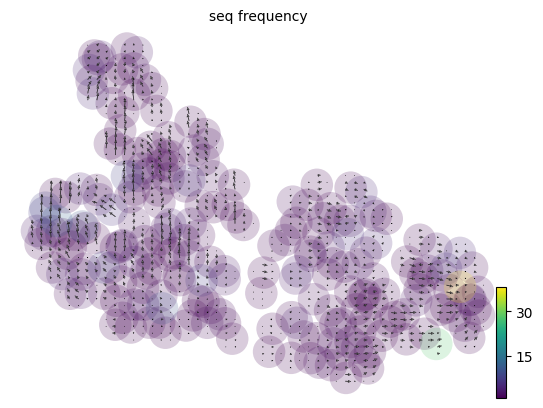

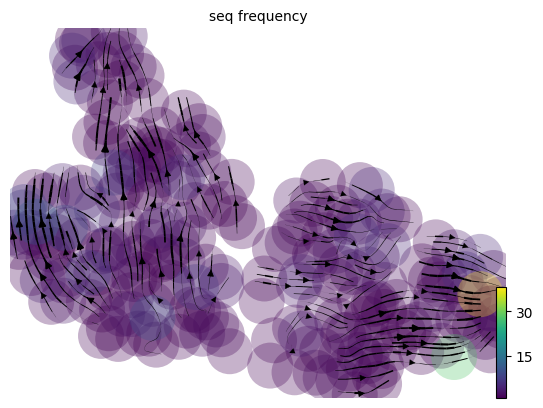

In [98]:
model = "sapiens"
sub_group = "IGHV1-4"
color = "seq_frequency"

# additional_cdn = model_dict[model][sub_group].obs["sample_id"] == "s2"

sc.tl.umap(model_dict_specific[model][sub_group])
evo.tl.velocity_embedding(model_dict_specific[model][sub_group])
evo.pl.velocity_embedding_grid(model_dict_specific[model][sub_group], color=color, legend_loc="right margin")
evo.pl.velocity_embedding_stream(model_dict_specific[model][sub_group],color =color, legend_loc="right margin")

In [7]:
data_folder_path = os.path.join("..","..","..","data",dataset,"VDJ")
cellranger_path = os.path.join(data_folder_path, "Influenza.vac.11.12.human.S4")   
embeddings_path = os.path.join(cellranger_path,"embeddings",mode,f"embeddings_ESM.csv.gzip")

embeddings_file = pd.read_csv(embeddings_path, compression="gzip")

In [9]:
embeddings_file["dim_0"]

0       -0.032617
1        0.023019
2        0.023512
3        0.002515
4        0.029496
           ...   
18598    0.005165
18599    0.023289
18600    0.007719
18601   -0.002924
18602   -0.039763
Name: dim_0, Length: 18603, dtype: float64